In [1]:
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
from tqdm import tqdm
import librosa
from numba import cuda
import librosa.display
import gc
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
from sklearn.preprocessing import LabelEncoder
from scipy import signal
from scipy.io import wavfile as wav
from numpy.lib import stride_tricks
from keras.layers import Conv2D, MaxPool2D, Flatten, LSTM, Dense, Dropout
from keras.models import Sequential
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd

Using TensorFlow backend.


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')

In [3]:
configuration = tf.compat.v1.ConfigProto()
configuration.gpu_options.per_process_gpu_memory_fraction = 0.5
tf.config.experimental.set_memory_growth(gpus[0],True)
session = tf.compat.v1.Session(config=configuration)

In [4]:
df = pd.read_csv('instruments.csv')

In [5]:
def build_feats():
    X = []
    Y = []
    for image in tqdm(os.listdir('./spectrograms2/')):
        X.append(mpimg.imread('./spectrograms2/' + image))
        temp = image.split('.')
        wavFile = temp[0] + '.wav'
        
        classname =df[df.fname == wavFile].label.values
        Y.append(classname[0])
    
    X = np.asarray(X)
    return X,Y

In [6]:
trainX,trainY = build_feats()

100%|███████████████████████████████████████| 300/300 [00:00<00:00, 497.50it/s]


In [7]:
trainX.shape

(300, 288, 432, 3)

In [8]:
trainY = np.asarray(trainY)
trainY = trainY.flatten()
label_encoder = LabelEncoder()
trainY = label_encoder.fit_transform(trainY)
trainY = tf.keras.utils.to_categorical(trainY,num_classes=10)

In [9]:
datagen = ImageDataGenerator(rescale=1.0/255.0)

In [10]:
train_iterator = datagen.flow(trainX, trainY, batch_size=16)

In [11]:
def get_conv_model():
    model = Sequential()
    model.add(Conv2D(64,kernel_size=3, activation = 'relu', input_shape=(288,432,3)))
    model.add(Conv2D(32,kernel_size=3, activation = 'relu'))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(32,activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    return model

In [12]:
conv_model = get_conv_model()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 286, 430, 64)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 284, 428, 32)      18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 142, 214, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 142, 214, 32)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 972416)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                31117344  
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

In [13]:
cnnScores = conv_model.fit_generator(train_iterator, steps_per_epoch=len(train_iterator), epochs=30)
# cnnScores = conv_model.fit(features,labels,epochs=30, batch_size=20, shuffle=False, validation_split=0.4)

Epoch 1/30
19/19 [==============================] - 5s 254ms/step - loss: 4.7241 - acc: 0.0967
Epoch 2/30
19/19 [==============================] - 2s 100ms/step - loss: 1.9941 - acc: 0.3800
Epoch 3/30
19/19 [==============================] - 2s 98ms/step - loss: 1.1228 - acc: 0.6067
Epoch 4/30
19/19 [==============================] - 2s 98ms/step - loss: 0.5562 - acc: 0.8167
Epoch 5/30
19/19 [==============================] - 2s 98ms/step - loss: 0.3604 - acc: 0.9033
Epoch 6/30
19/19 [==============================] - 2s 99ms/step - loss: 0.2244 - acc: 0.9300
Epoch 7/30
19/19 [==============================] - 2s 98ms/step - loss: 0.2097 - acc: 0.9367
Epoch 8/30
19/19 [==============================] - 2s 98ms/step - loss: 0.0660 - acc: 0.9800
Epoch 9/30
19/19 [==============================] - 2s 98ms/step - loss: 0.0408 - acc: 0.9900
Epoch 10/30
19/19 [==============================] - 2s 98ms/step - loss: 0.0573 - acc: 0.9767
Epoch 11/30
19/19 [==============================] - 2s 9

In [ ]:
#_, acc = model.evaluate_generator(test_iterator, steps=len(test_iterator), verbose=0)

In [ ]:
cnnScores.history

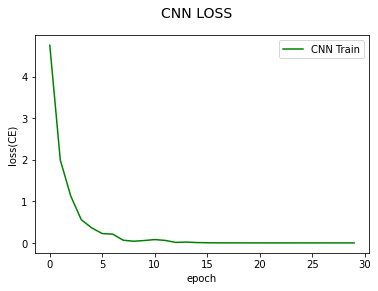

In [14]:
fig = plt.figure()
fig.suptitle('CNN LOSS', fontsize=14)
# pyplot.plot(cnnScores.history['val_loss'],label="CNN Train", color="red")
plt.plot(cnnScores.history['loss'],label="CNN Train", color="green")

plt.xlabel('epoch')
plt.ylabel('loss(CE)')
plt.legend()
plt.show()

In [ ]:
cuda.select_device(0)
cuda.close()